In [1]:
import os,sys
import cPickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from time import time

sys.path.insert(0,'lib/')
import config
import diagnostics
import base_model
os.environ['CUDA_VISIBLE_DEVICES']='3'
from sklearn.metrics import average_precision_score

import tensorflow as tf

%matplotlib inline

In [2]:
with open(config.labels_path) as f:
    labels = pickle.load(f)

In [3]:
# windowed, exponentially distributed filters between 50Hz and 22kHz
def create_filters(d,k):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((1,d,1,k), dtype=np.float32)
    wcos = np.empty((1,d,1,k), dtype=np.float32)
    start_freq = 50.
    end_freq = 6000.
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[0,:,0,ind] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[0,:,0,ind] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
            
    return wsin,wcos

class Spectrograms(base_model.Model):
    def __init__(self, *args, **kwargs):
        super(Spectrograms, self).__init__(*args, **kwargs)

    def define_graph(self):
        super(Spectrograms, self).define_graph()
        
        # lvl1 convolutions are shared between regions
        self.k = 512              # lvl1 nodes
        self.d = 4096              # lvl1 receptive field
        
        self.k2 = 512              # lvl2 nodes

        # number of lvl1 features
        regions = 1 + (self.window - self.d)/self.stride
        print 'Number of V1 feature regions: {}'.format(regions)

        wsin,wcos = create_filters(self.d,self.k)
        
        wscale = 10e-5
        with tf.variable_scope('parameters'):
            w1 = tf.Variable(wscale*tf.random_normal([regions*self.k,self.k2],seed=999))
            w1avg = self.register_weights(w1,'w1',average=.9998)
            beta = tf.Variable(wscale*tf.random_normal([self.k2,self.m],seed=999))
            betaavg = self.register_weights(beta,'beta',average=.9998)

        with tf.variable_scope('queued_model'):
            zx = tf.square(tf.nn.conv2d(self.xq,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
               + tf.square(tf.nn.conv2d(self.xq,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            z2 = tf.nn.relu(tf.matmul(tf.reshape(tf.log(zx + 10e-12),[self.batch_size,regions*self.k]),w1))
            y = tf.matmul(z2,beta)
            self.loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(self.yq,[self.batch_size,self.m])))

        with tf.variable_scope('direct_model'):
            zx = tf.square(tf.nn.conv2d(self.xd,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
               + tf.square(tf.nn.conv2d(self.xd,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            z2 = tf.nn.relu(tf.matmul(tf.reshape(tf.log(zx + 10e-12),[tf.shape(self.xd)[0],regions*self.k]),w1avg))
            self.y_direct = tf.matmul(z2,betaavg)
            self.loss_direct = tf.reduce_mean(tf.nn.l2_loss(self.y_direct-self.yd))

In [4]:
model = Spectrograms(labels,checkpoint_path='/mlp', outputs=1, window=16384, mmap=True, batch_size=100,
                    normalize=True, extended_test_set=True, use_mirex=False, init=True, pitch_transforms=5, jitter=.1,
                    restrict=False)

Number of V1 feature regions: 25
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [40]:
lr = .000001/3/3
mom = .95

# stop the model if it is already running
model.stop()

# we have to rebuild the graph every time because input queues can't be reopened
model.define_graph()

learning_rate = tf.placeholder(tf.float32, shape=[])
opt_op = tf.train.MomentumOptimizer(learning_rate,mom).minimize(model.loss)
with tf.control_dependencies([opt_op]):
    train_step = tf.group(*model.averages)

# start up the session, kick off the worker threads, restore checkpoint, etc.
model.start()

try:
    ptime = time()
    print model.status_header()
    
    while True:
        if model.iter % 10000 == 0:
            model.update_status(ptime,time(),lr)
            model.checkpoint()
            print model.status()
            ptime = time()

        model.sess.run(train_step, feed_dict={learning_rate: lr})
        model.iter += 1

except KeyboardInterrupt:
    model.checkpoint()
    print 'Graceful Exit'
finally:
    model.stop()

Number of V1 feature regions: 25
avp_test	avp_train	mse_test	mse_train	time	utime


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [47]:
model.weights

{'avg_beta': <tf.Variable 'parameters/Variable_3:0' shape=(512, 128) dtype=float32_ref>,
 'avg_w1': <tf.Variable 'parameters/Variable_1:0' shape=(12800, 512) dtype=float32_ref>,
 'beta': <tf.Variable 'parameters/Variable_2:0' shape=(512, 128) dtype=float32_ref>,
 'w1': <tf.Variable 'parameters/Variable:0' shape=(12800, 512) dtype=float32_ref>}

In [48]:
w1 = model.sess.run(model.weights['w1'])
beta = model.sess.run(model.weights['beta'])

In [52]:
result_dict = {}

In [54]:
result_dict['w1'] = w1
result_dict['beta'] = beta

In [ ]:
num

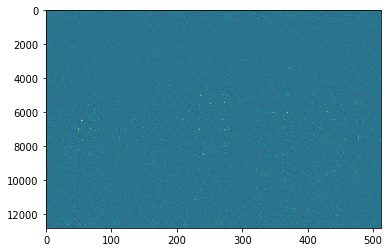

In [50]:
plt.imshow(w1, aspect='auto')

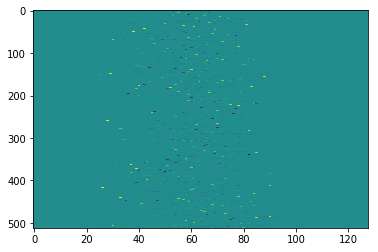

In [51]:
plt.imshow(beta, aspect='auto')

In [39]:
tf.convert_to_tensor(w1)

<tf.Tensor 'parameters/Variable/read:0' shape=(12800, 512) dtype=float32>